## WEC Analysis - NLP + coding

*Created 12/03/2019*

This notebook is the core of the analysis of results, including further NLP steps such as looking for collocations, counting occurrences and saving and loading files for manual coding.

In [7]:
from nltk import QuadgramCollocationFinder,TrigramCollocationFinder,BigramCollocationFinder,FreqDist
from nltk.corpus import stopwords
from nltk.parse import CoreNLPParser
from itertools import groupby
from operator import itemgetter
from matplotlib import pyplot
import pandas as pd
import numpy as np
import csv
from IPython.display import HTML, display
import tabulate

In [8]:
en_stopws = stopwords.words('english') #Load common stopwords
pos_tagger = CoreNLPParser(url='http://localhost:9500', tagtype='pos')
excs = set([])
Qs = ["C8P","C6P","C4P","C2P","C0","C2N","C4N","C6N","C8N"]
orderedQ = {'C8P': '9_C8P','C6P': '8_C6P','C4P': '7_C4P','C2P': '6_C2P','C0': '5_C0','C2N': '4_C2N','C4N': '3_C4N','C6N': '2_C6N','C8N': '1_C8N'}
floatQ = {'C8P': 0.8,'C6P': 0.6,'C4P':0.4,'C2P':0.2,'C0': 0,'C2N': -0.2,'C4N': -0.4,'C6N':-0.6,'C8N': -0.8}

In [9]:
def print_pairs_na(pairs,fname):
    with open(fname,'w') as f:
        f.write('Nouns\t Adjectives\n')
        for pair in pairs:
            f.write(','.join(pair[0])+'\t'+pair[1]+'\n')

In [3]:
#Load previsouly processed data
data = pd.read_pickle("WECdf.pkl")

[('varb', 852),
 ('vara', 850),
 ('variable', 506),
 ('relationship', 348),
 ('correlation', 328),
 ('increase', 316),
 ('high', 256),
 ('low', 169),
 ('seem', 151),
 ('value', 140),
 ('data', 139),
 ('appear', 129),
 ('scatter', 129),
 ('point', 121),
 ('positive', 116),
 ('negative', 98),
 ('decrease', 97),
 ('chart', 90),
 ('random', 90),
 ('show', 78),
 ('clear', 69),
 ('trend', 67),
 ('strong', 63),
 ('number', 58),
 ('line', 54),
 ('middle', 54),
 ('dot', 54),
 ('graph', 52),
 ('weak', 51),
 ('two', 51)]

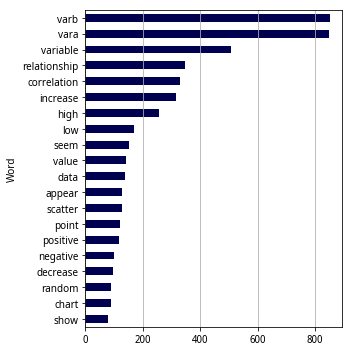

In [10]:
pos_counts = FreqDist()
for sent in data.itertuples(index=True):
    ws = [func for word,func in sent.lemmatized if (word not in en_stopws)]
    pos_counts.update(ws)#word for word in tokens if (word not in stopws))
#pos_counts.plot(5)

lemma_counts = FreqDist()
for sent in data.itertuples(index=True):
    ws = [word for word,func in sent.lemmatized if (word not in en_stopws)]
    lemma_counts.update(ws)#word for word in tokens if (word not in stopws))
#for f,s in lemma_counts.most_common(30):
#    df.
display(lemma_counts.most_common(30))
hfont = {'fontname':'Merriweather Sans'}
lcd = pd.DataFrame(lemma_counts.most_common(20),columns=['Word','Count'])
lcd = lcd.sort_values(by=['Count'],axis=0,ascending=True)
ax = lcd.plot(kind='barh',x='Word', y='Count',figsize=(5,5),legend=False,color='#000050')
ax.xaxis.grid(True)
pyplot.rcParams["font.family"] = "Noto Sans"
pyplot.tight_layout()
#pyplot.savefig('word-count2.pdf')
#alt.Chart(lcd).mark_bar().encode(x=alt.X('Count',title=""),y=alt.Y('Word',title='',sort=alt.EncodingSortField(
#            field="yield",  # The field to use for the sort
#            op="sum",  # The operation to run on the field prior to sorting
#            order="descending"  # The order to sort in
#        ))).properties(width=250,height=250)

This overview allows us to decide the initial steps in our investigation and some initial conclusions regarding the preference on some easily distinguishable topics. As an example, we notice how a large number (>800) of answers include direct references to the variables, or to the word variable (in singular and plural forms). At this stage, however, we don't know what types of words and themes go along with them. We can count simple tokenized words, as well as words that have been *lemmatized*, that is, their plural forms have been reduced to singular forms, and transformation of verb tenses. In our case, the difference between some tenses do not matter, such as present and past. The lemmmatization process combines *correlate* and *correlated* into a single *correlate* word.

As a next step, based on the number of potential nouns in the list, we investigate which concepts are present in the form of nouns and what types of adjectives modify these nouns. We first extract the 20 most common nouns from the list of lemmatized tokens, excluding those in variable *excs* (this can vary, at the moment it's empty) and with length <= 1, keeping them in the *mcn* list.

In [11]:
nn_tags = []
mcn = FreqDist()
for sent in data.itertuples():
    for word,tag in sent.lemmatized:
        if (tag.startswith("NN") and (len(word) > 1) and (word not in excs)):
            mcn.update([word])
mcn.most_common(20)

[('varb', 852),
 ('vara', 850),
 ('variable', 506),
 ('relationship', 348),
 ('correlation', 328),
 ('value', 140),
 ('data', 139),
 ('point', 121),
 ('increase', 112),
 ('chart', 90),
 ('trend', 67),
 ('number', 58),
 ('line', 54),
 ('dot', 54),
 ('graph', 52),
 ('decrease', 51),
 ('pattern', 43),
 ('result', 40),
 ('outlier', 39),
 ('middle', 34)]

Some of these evidently overlap with the overall word count, but increase is only considered in its noun form, so it drops down the list. After the proper nouns referring to the variables and the word variable, participants focused on relationship and correlation. Further down the list the word count decreases substantially (the 10th most common noun, chart, occurs 8 times less than the most common ones). 

Relationship slightly outnumbers correlation -- as the task asked participants to "describe the relationship", this is not surprising.

In [12]:
mean_answer = data.groupby('Question')['lemmatized'].apply(len).mean()
data['word_count'] = data.tokenized.apply(len) #.mean()
display(data.word_count.mean())
#display(data[data['word_count'] == 97].Answer.to_list())
data.groupby('Question').describe()['word_count'][['mean','std','min','max']].T #%,'25%','50%','75%']].T

12.015406162464986

Question,C0,C2N,C2P,C4N,C4P,C6N,C6P,C8N,C8P
mean,11.143750,12.60000,11.762500,11.531250,12.606250,12.643750,12.559748,11.450000,11.832215
std,8.783093,10.65892,9.487819,9.341812,9.792885,10.943737,9.558343,7.976223,7.895776
min,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,43.000000,57.00000,62.000000,55.000000,66.000000,97.000000,66.000000,37.000000,40.000000


### Adjectives

As a next step, we look at the words that appear along with common nouns. Of particular interest are the adjectives.

For that, we specify bigrams and trigrams filters for pairs of (adjective,nouns). (To limit the number of bigrams, we focus on the list of 20 most common nouns above, excluding the nouns not in that list.)

In [51]:
#Specify a filter to capture only adjectives that are going along common nouns (not proper nouns such as VarA and VarB)
def bigram_filter(w1,w2):
    #print(w1,w2)
    return not (((w1[1].startswith("JJ")) and (w2[1] == "NN"))
                or ((w1[1].startswith("JJ")) and (w2[1] == "NN")))

In [52]:
#Specify a filter to capture only adjectives that are going along common nouns (not proper nouns such as VarA and VarB)
def bigram_filter2(w1,w2):
    return not (((w1[1] == "JJ") and (w2[1] == "NN"))
                or ((w1[1] == "JJ") and (w2[1] == "NNS")))

In [53]:
bigrams = BigramCollocationFinder.from_documents(data['lemmatized'])
bigrams.apply_ngram_filter(bigram_filter)
#bigrams.apply_ngram_filter(lambda w1,w2: not ((w1[0] in magscale))) and (noun_cat[w2[0]] == 'RELATION' if w2[0] in noun_cat else True)))
#bigrams.apply_ngram_filter(lambda w1,w2: not (noun_cat[w2[0]] == 'RELATION' if w2[0] in noun_cat else True))
#bigrams.apply_ngram_filter(lambda w1,w2: not (adj_cat[w1[0]] == 'MAGNITUDE' if w1[0] in adj_cat else True))

#Convert them to a list so we can sort them by frequency
bigram_list = list(bigrams.ngram_fd.items())
bigram_list.sort(key=lambda item: item[-1], reverse=True)
#for a,b in bigram_list:
#    print(a[0][0],a[1][0],b)
bigram_list[:5]

[((('positive', 'JJ'), ('correlation', 'NN')), 79),
 ((('negative', 'JJ'), ('correlation', 'NN')), 72),
 ((('clear', 'JJ'), ('relationship', 'NN')), 28),
 ((('positive', 'JJ'), ('relationship', 'NN')), 26),
 ((('linear', 'JJ'), ('relationship', 'NN')), 22)]

In [54]:
# Group adjectives by nouns
groups = []
ngram = sorted(bigram_list,key=lambda item: item[0][1][0])
for k, g in groupby(ngram, key=lambda item: item[0][1][0]):
    vals = [itemgetter(0)(i) for i in list(g)]
    groups.append((list(set([v[0][0] for v in vals])),k))
#groups
groups.sort(key=lambda t: len(t[0]), reverse=True)
#groups
fgroups = [element for element in groups if (len(element[0]) >= 1)]
fgroups[:1]
#print_pairs_na(fgroups,'adj-noun-all.tsv') # This saves the file so we can manually code the nouns

[(['similar',
   'discernible',
   'clear',
   'real',
   'proportional',
   'diagonal',
   'active',
   'good',
   'vague',
   'positive',
   'inversely-proportional',
   'predictable',
   'linear',
   'constant',
   'causal',
   'direct',
   'much',
   'slight',
   'random',
   'moderate',
   'strong',
   'minimal',
   'casual',
   'noticeable',
   'small',
   'little',
   'symmetrical',
   'inverse',
   'particular',
   'distinct',
   'weak',
   'identifiable',
   'loose',
   'common',
   'obvious',
   'negative',
   'consistent'],
  'relationship')]

In [55]:
# Group nouns by adjectives
groups = []
uniquekeys = []
ngram = sorted(bigram_list,key=lambda item: item[0][0][0])
for k, g in groupby(ngram, key=lambda item: item[0][0][0]):
    vals = [itemgetter(0)(i) for i in list(g)]
    groups.append(([v[1][0] for v in vals],k))
    uniquekeys.append(k)
#groups
groups.sort(key=lambda t: len(t[0]), reverse=True)
#groups
fgroups = [element for element in groups if (len(element[0]) >= 1)]
fgroups[:2]
#print_pairs_na(fgroups,'noun-adj-all.tsv') # This saves the file so we can manually code the adjectives

[(['variable',
   'value',
   'b',
   'value',
   'variable',
   'number',
   'concentration',
   'amount',
   'b',
   'r',
   'point',
   'correlation',
   'quantity',
   'number',
   'increase',
   'variable',
   'frequency',
   'density',
   'number',
   'variability',
   'degree',
   'end',
   'incidence',
   'end',
   'range'],
  'high'),
 (['end',
   'value',
   'variable',
   'confidence',
   'b',
   'section',
   'incidence',
   'scattering',
   'amount',
   'increase',
   'likelihood',
   'variable',
   'vice',
   'point',
   'status'],
  'low')]

From the above, we can see that participants use a wide range of adjectives to describe correlation and relationship, and these overlap quite a bit. We need to remember that when looking for bigrams, we are not checking if the words are preceded by "no" or "not". But at this stage we are not looking for the association between bigrams and the answers, so it doesn't really matter.

In addition to relationship and correlation, several other concepts appear here: pattern, trend, range, increase, rate, scattering, anomaly/outlier, association, cluster. There are also references to shapes: dot, line, point, graph.

In terms of adjectives, for relationship and correlation, participants focused mostly on their magnitude.
The adjectives used for pattern refer to how perceptible it was. For trend, people refer to its direction, magnitude and perceptibility. 

We continue the analysis by expanding into trigrams to look for double adjectives.

In [56]:
def trigram_filter(w1,w2,w3):
    return not (w1[1].startswith("JJ") and w2[1].startswith("JJ") and w3[1].startswith("NN"))

In [57]:
trigrams = TrigramCollocationFinder.from_documents(data['lemmatized'].tolist())
trigrams.apply_ngram_filter(trigram_filter)
#trigrams.apply_ngram_filter(lambda w1,w2,w3: not ((w1[0] in magscale) and (noun_cat[w3[0]] == 'RELATION' if w3[0] in noun_cat else True)))
trigrams.apply_ngram_filter(lambda w1,w2,w3: not (noun_cat[w3[0]] == 'RELATION' if w3[0] in noun_cat else True))
#trigrams.apply_ngram_filter(lambda w1,w2,w3: not (noun_cat[w1[0]] == 'MAGNITUDE' if w3[0] in noun_cat else True))
trigram = list(trigrams.ngram_fd.items())
trigram.sort(key=lambda item: item[-1], reverse=True)
trigram

[((('weak', 'JJ'), ('positive', 'JJ'), ('correlation', 'NN')), 14),
 ((('slight', 'JJ'), ('negative', 'JJ'), ('correlation', 'NN')), 13),
 ((('strong', 'JJ'), ('positive', 'JJ'), ('correlation', 'NN')), 10),
 ((('slight', 'JJ'), ('positive', 'JJ'), ('correlation', 'NN')), 10),
 ((('weak', 'JJ'), ('negative', 'JJ'), ('correlation', 'NN')), 9),
 ((('strong', 'JJ'), ('negative', 'JJ'), ('correlation', 'NN')), 8),
 ((('strong', 'JJ'), ('positive', 'JJ'), ('relationship', 'NN')), 4),
 ((('slight', 'JJ'), ('positive', 'JJ'), ('relationship', 'NN')), 4),
 ((('moderate', 'JJ'), ('negative', 'JJ'), ('relationship', 'NN')), 4),
 ((('negative', 'JJ'), ('linear', 'JJ'), ('relationship', 'NN')), 4),
 ((('moderate', 'JJ'), ('positive', 'JJ'), ('relationship', 'NN')), 3),
 ((('loose', 'JJ'), ('positive', 'JJ'), ('correlation', 'NN')), 3),
 ((('positive', 'JJ'), ('linear', 'JJ'), ('relationship', 'NN')), 2),
 ((('low', 'JJ'), ('positive', 'JJ'), ('correlation', 'NN')), 2),
 ((('mild', 'JJ'), ('direct'

Compared to the bigrams, there is not a great difference in terms of which adjectives appear, however, we can notice that there is a long tail of trigrams with only a single occurrence. We can now compute the overall occurrences of adjectives used in collocations in the whole data.

In [58]:
bjj = [(jj[0][0][0],jj[1]) for jj in bigrams.ngram_fd.items() if jj[0][0][1].startswith("JJ")]
bigram_jj_nocount = [jj[0][0][0] for jj in bigrams.ngram_fd.items() if jj[0][0][1].startswith("JJ")]
tjj = [(jj[0][0][0],jj[1]) for jj in trigrams.ngram_fd.items() if (jj[0][0][0] not in bjj) and (jj[0][0][1].startswith("JJ"))]
trigram_jj_nocount = [jj[0][0][0] for jj in trigrams.ngram_fd.items() if (jj[0][0][0] not in bjj) and (jj[0][0][1].startswith("JJ"))]


In [60]:
bnn = [(nn[0][1][0],nn[1]) for nn in bigrams.ngram_fd.items() if nn[0][1][1].startswith("NN")]
bigram_nn_nocount = [jj[0][1][0] for jj in bigrams.ngram_fd.items() if jj[0][1][1].startswith("NN")]
tnn = [(jj[0][1][0],jj[1]) for jj in trigrams.ngram_fd.items() if (jj[0][1][0] not in bjj) and (jj[0][1][1].startswith("NN"))]
trigram_nn_nocount = [jj[0][1][0] for jj in trigrams.ngram_fd.items() if (jj[0][1][0] not in bjj) and (jj[0][1][1].startswith("NN"))]
#bjj.remove('positive')
#bjj.remove('negative')
#bjj.remove('direct')


In [62]:
adjs = set(bigram_nn_nocount + trigram_nn_nocount)
adjs = list(adjs)
#adjs.remove('positive')
#adjs.remove('negative')
_C = {}
for l in bjj, tjj:
    for d in l:
        _C[d[0]] = int(d[1]) +int(_C.get(d[0], 0))

adjs2 = [(k,c) for (k, c) in _C.items()]
#dict(adjs2)
#print(list(filter(lambda x: x[1] > 1,adjs2))[:10])
adjs2 = sorted(adjs2,key=lambda x: -x[1])
#for a in adjs2:
#    print(sorted(adj))
#print(adjs2[:10])
adjs2[:20]

[('positive', 110),
 ('negative', 94),
 ('clear', 57),
 ('high', 53),
 ('strong', 49),
 ('slight', 48),
 ('weak', 46),
 ('low', 40),
 ('linear', 38),
 ('obvious', 21),
 ('loose', 21),
 ('little', 19),
 ('direct', 17),
 ('diagonal', 16),
 ('wide', 13),
 ('general', 12),
 ('random', 12),
 ('same', 11),
 ('steady', 11),
 ('inverse', 11)]

In [63]:
nouns = set(bigram_nn_nocount + trigram_nn_nocount)
nouns = list(nouns)
#adjs.remove('positive')
#adjs.remove('negative')
_C = {}
for l in bnn, tnn:
    for d in l:
        _C[d[0]] = int(d[1]) +int(_C.get(d[0], 0))

nouns2 = [(k,c) for (k, c) in _C.items()]
dict(nouns2)
#print(list(filter(lambda x: x[1] > 1,adjs2))[:10])
nouns2 = sorted(nouns2,key=lambda x: -x[1])
#for a in adjs2:
#    print(sorted(adj))
#print(adjs2[:10])
nouns2[:20]

[('correlation', 243),
 ('relationship', 185),
 ('trend', 31),
 ('variable', 29),
 ('pattern', 27),
 ('value', 19),
 ('line', 16),
 ('range', 16),
 ('increase', 15),
 ('spread', 14),
 ('rate', 13),
 ('b', 9),
 ('part', 9),
 ('scattering', 9),
 ('end', 9),
 ('sloping', 8),
 ('amount', 8),
 ('association', 7),
 ('cluster', 7),
 ('number', 6)]

### Adjective use per correlation

In [64]:
#Function that gets all the adjectives that go along with the filterWords, returning them as tuples
#Dependencies:
def get_all_adjs_as_tuple(ls,filterWords):
    
    finder = BigramCollocationFinder.from_documents(ls)
    finder.apply_ngram_filter(bigram_filter)
#    finder.apply_ngram_filter(lambda w1,w2: not (w2[0] in mcn))
    if (len(filterWords) > 0):
        finder.apply_ngram_filter(lambda w1, w2: not (w2[0] in filterWords))
    bigram_adjs = [(jj[0][0][0],jj[1]) for jj in finder.ngram_fd.items() if jj[0][0][1].startswith("JJ")]
    
    trigrams = TrigramCollocationFinder.from_documents(ls)
    trigrams.apply_ngram_filter(trigram_filter)
    if (len(filterWords) > 0):
        trigrams.apply_ngram_filter(lambda w1, w2, w3: not ((w2[0] in filterWords) or (w3[0] in filterWords)))
    trigram_adjs = [(jj[0][0][0],jj[1]) for jj in trigrams.ngram_fd.items() if (jj[0][0][0] not in bjj) and (jj[0][0][1].startswith("JJ"))]
    
    _C = {}
    for l in bigram_adjs, trigram_adjs:
        for d in l:
            _C[d[0]] = int(d[1]) +int(_C.get(d[0], 0))

    adjs2 = {(k,c) for (k, c) in _C.items()}
    return adjs2

In [65]:
#Function that gets all the adjectives that go along with the filterWords, returning them as tuples
#Dependencies:
def get_nouns_tuple(ls,filterWords):
    
    finder = BigramCollocationFinder.from_documents(ls)
    finder.apply_ngram_filter(bigram_filter)
   # finder.apply_ngram_filter(lambda w1,w2: (w2[1] == "NNP"))
    bigram_adjs = [(jj[0][1][0],jj[1]) for jj in finder.ngram_fd.items() if jj[0][1][1].startswith("NN")]
    
    trigrams = TrigramCollocationFinder.from_documents(ls)
    trigrams.apply_ngram_filter(trigram_filter)
    trigram_adjs = [(jj[0][0][0],jj[1]) for jj in trigrams.ngram_fd.items() if (jj[0][0][0] not in bjj) and (jj[0][0][1].startswith("JJ"))]
    
    _C = {}
    for l in bigram_adjs, trigram_adjs:
        for d in l:
            _C[d[0]] = int(d[1]) +int(_C.get(d[0], 0))

    adjs2 = {(k,c) for (k, c) in _C.items()}
    return adjs2

In [66]:
#Function that gets all the adjectives that go along with the filterWords
#Dependencies:
def get_all_adjs(ls,filterWords):
    mcn = FreqDist()
    #print(ls)
    for sent in ls:
        for word,tag in sent:
            if (tag.startswith("NN") and (len(word) > 1)):
                mcn.update([word])
    finder = BigramCollocationFinder.from_documents(ls)
    finder.apply_ngram_filter(bigram_filter)
#    finder.apply_ngram_filter(lambda w1,w2: not (w2[0] in mcn))
    if (len(filterWords) > 0):
        finder.apply_ngram_filter(lambda w1, w2: not (w2[0] in filterWords))
    bigram_adjs = [(jj[0][0][0],jj[1]) for jj in finder.ngram_fd.items() if jj[0][0][1].startswith("JJ")]
    trigrams = TrigramCollocationFinder.from_documents(ls)
    trigrams.apply_ngram_filter(trigram_filter)
    if (len(filterWords) > 0):
        trigrams.apply_ngram_filter(lambda w1, w2, w3: not ((w2[0] in filterWords) or (w3[0] in filterWords)))
    trigram_adjs = [(jj[0][0][0],jj[1]) for jj in trigrams.ngram_fd.items() if (jj[0][0][0] not in bjj) and (jj[0][0][1].startswith("JJ"))]
    _C = {}
    for l in bigram_adjs, trigram_adjs:
        for d in l:
            _C[d[0]] = int(d[1]) +int(_C.get(d[0], 0))

    adjs2 = {k: c for (k, c) in _C.items()}
    return adjs2

In [67]:
## Gets lemmatized sentences and group them by question
adjs_by_q_dict = {}
adjs_by_q = {}
for q in Qs:
    lq = data[data['Question'] == q]['lemmatized']
    fw = ['correlation','relationship']
    adjs_by_q[q] = get_all_adjs_as_tuple(lq,[])
    adjs_by_q_dict[q] = get_all_adjs(lq,[])

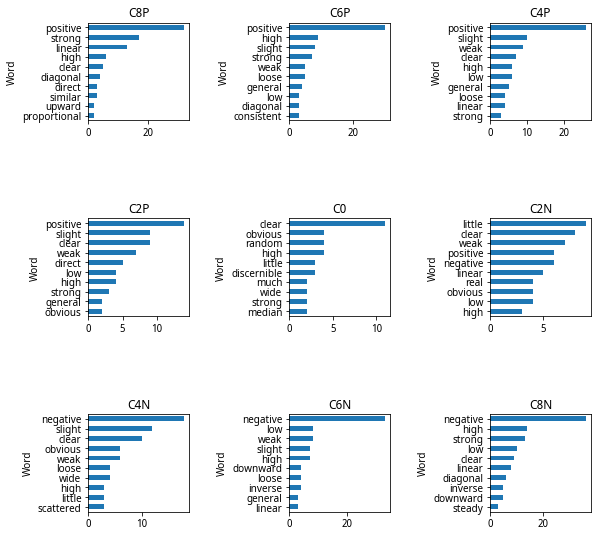

In [68]:
fig, axes = pyplot.subplots(nrows=3, ncols=3,figsize=(24,24))
fig.subplots_adjust(wspace=1,hspace=1)
x = 0
for k in adjs_by_q:
    #display(sorted(adjs_by_q[k],key=lambda x: -x[1])[:10])
#    print(k)
 #   for w in sorted(faq[k],key=lambda x: -x[1]):
 #       print(w[0]+'\t'+str(w[1]))
 #   print (",")
    lcd2 = pd.DataFrame(list(adjs_by_q[k]),columns=['Word','Count'])
    lcd2 = lcd2.sort_values(by=['Count'],axis=0,ascending=True)
    ax = lcd2.tail(10).plot(kind='barh',x='Word', y='Count',title=k,figsize=(9,9),legend=False,ax=axes[x // 3,x % 3])
    x = x +1

In [69]:
aCounts = {}
for adjective,count in adjs2[:20]:   
    aCounts[adjective] = []
    for q in adjs_by_q_dict:        
        if adjective in adjs_by_q_dict[q]:
            aCounts[adjective].append(adjs_by_q_dict[q][adjective])
        else:
            aCounts[adjective].append(0)
display(aCounts)
#print('Word\t-8\t-6\t-4\t-2\t0\t2\t4\t6\t8')
#for k in aCounts:
#    print(k,'\t','\t'.join(map(str, aCounts[k])))

{'positive': [32, 30, 26, 14, 1, 6, 0, 0, 1],
 'negative': [0, 0, 1, 0, 0, 6, 18, 33, 36],
 'clear': [5, 0, 7, 9, 11, 8, 10, 0, 9],
 'high': [6, 9, 6, 4, 4, 3, 3, 7, 14],
 'strong': [17, 7, 3, 3, 2, 2, 1, 3, 13],
 'slight': [0, 8, 10, 9, 0, 1, 12, 7, 2],
 'weak': [2, 5, 9, 7, 1, 7, 6, 8, 1],
 'low': [1, 3, 6, 4, 2, 4, 2, 8, 10],
 'linear': [13, 3, 4, 1, 1, 5, 1, 3, 8],
 'obvious': [1, 1, 3, 2, 4, 4, 6, 0, 0],
 'loose': [1, 5, 4, 1, 0, 2, 4, 4, 0],
 'little': [1, 0, 1, 2, 3, 9, 3, 0, 0],
 'direct': [3, 3, 1, 5, 1, 2, 1, 0, 1],
 'diagonal': [4, 3, 0, 0, 0, 1, 1, 1, 6],
 'wide': [0, 1, 1, 2, 2, 0, 4, 3, 0],
 'general': [1, 4, 5, 2, 0, 0, 1, 3, 1],
 'random': [0, 0, 3, 2, 4, 1, 2, 0, 0],
 'same': [2, 1, 3, 1, 1, 2, 0, 1, 0],
 'steady': [2, 2, 1, 2, 0, 0, 0, 2, 3],
 'inverse': [0, 0, 0, 1, 0, 0, 1, 4, 5]}

In [80]:
df = pd.DataFrame()
for k in adjs_by_q:
    df = pd.concat([pd.DataFrame(sorted(adjs_by_q[k],key=lambda x: -x[1])[:10]),df],axis=1,join='outer')
#    display(sorted(adjs_by_q[k],key=lambda x: -x[1])[:10])
df.to_csv('adj_by_corr.csv')
#df_adj_count = pd.DataFrame(adjs_by_q_dict).T.reset_index().melt(id_vars='index',var_name='Word',value_name='Count')
#alt.Chart(df_adj_count).mark_line().encode(x='index:O',y='Count:N',color='Word:O')

In [79]:
df

,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1
0,negative,36,negative,33,negative,18,little,9,clear,11,positive,14,positive,26,positive,30,positive,32
1,high,14,low,8,slight,12,clear,8,random,4,clear,9,slight,10,high,9,strong,17
2,strong,13,weak,8,clear,10,weak,7,high,4,slight,9,weak,9,slight,8,linear,13
3,low,10,high,7,weak,6,positive,6,obvious,4,weak,7,clear,7,strong,7,high,6
4,clear,9,slight,7,obvious,6,negative,6,discernible,3,direct,5,high,6,loose,5,clear,5
5,linear,8,downward,4,wide,4,linear,5,little,3,low,4,low,6,weak,5,diagonal,4
6,diagonal,6,inverse,4,loose,4,low,4,strong,2,high,4,general,5,general,4,similar,3
7,inverse,5,loose,4,vague,3,obvious,4,wide,2,strong,3,linear,4,diagonal,3,direct,3
8,downward,5,strong,3,scattered,3,real,4,much,2,little,2,loose,4,consistent,3,most,2
9,steady,3,linear,3,little,3,high,3,median,2,random,2,strong,3,linear,3,weak,2


### Verbs and Adverbs

We now apply the same methods that we used to analyse adjectives and nouns to look for verbs and adverbs.

In [65]:
def adverb_filter(w1,w2):
# return not ( ((w1[1].startswith("RB")) and (w2[1].startswith("VB"))) 
 return not (((w1[1].startswith("RB")) and (w2[1].startswith("VB"))))
#                or ((w1[1].startswith("RB")) and (w2[1].startswith("JJ"))))

In [66]:
def adverb_trigram_filter(w1,w2,w3):
# return not ( ((w1[1].startswith("RB")) and (w2[1].startswith("VB"))) 
 return not ((w2[1].startswith("RB")) and (w3[1].startswith("VB")))

In [973]:
bigrams = BigramCollocationFinder.from_documents(data['lemmatized'].tolist())
#bigrams.apply_ngram_filter(lambda w1,w2: not ((w2[0] in mcn)))
bigrams.apply_ngram_filter(adverb_filter)
#finder.apply_ngram_filter(lambda w1, w2: not ((w2[0] == "relationship") or (w2[0] == "correlation")))
#bigrams.apply_freq_filter(2)

#Convert them to a list so we can sort them by frequency
adverb_bigram_list = list(bigrams.ngram_fd.items())
adverb_bigram_list.sort(key=lambda item: item[-1], reverse=True)
#for a,b in bigram_list:
#    print(a[0][0],a[1][0],b)
adverb_bigram_list
#print_pairs_na(adverb_bigram_list,'adverbs.csv') # Save the list to files

[((('so', 'RB'), ('do', 'VBZ')), 42),
 ((('there', 'RB'), ('appear', 'VBZ')), 42),
 ((('there', 'RB'), ('seem', 'VBZ')), 38),
 ((('very', 'RB'), ('scatter', 'VBN')), 20),
 ((('not', 'RB'), ('appear', 'VB')), 16),
 ((('also', 'RB'), ('increase', 'VBZ')), 13),
 ((('there', 'RB'), ('do', 'VBZ')), 13),
 ((('there', 'RB'), ('s', 'VBZ')), 8),
 ((('not', 'RB'), ('seem', 'VB')), 7),
 ((('evenly', 'RB'), ('distribute', 'VBN')), 6),
 ((('widely', 'RB'), ('spread', 'VBN')), 6),
 ((('even', 'RB'), ('spread', 'VBN')), 5),
 ((('fairly', 'RB'), ('scatter', 'VBN')), 5),
 ((('evenly', 'RB'), ('spread', 'VBN')), 5),
 ((('quite', 'RB'), ('scatter', 'VBN')), 5),
 ((('so', 'RB'), ('be', 'VBZ')), 4),
 ((('also', 'RB'), ('decrease', 'VBZ')), 4),
 ((('widely', 'RB'), ('scatter', 'VBN')), 3),
 ((('not', 'RB'), ('see', 'VB')), 3),
 ((('evenly', 'RB'), ('scatter', 'VBN')), 3),
 ((('widely', 'RB'), ('distribute', 'VBN')), 2),
 ((('always', 'RB'), ('have', 'VBP')), 2),
 ((('too', 'RB'), ('do', 'VBZ')), 2),
 ((('ge

In [36]:
# Group verbs by adverbs
groups = []
uniquekeys = []
ngram = sorted(adverb_bigram_list,key=lambda item: item[0][1][0])
for k, g in groupby(ngram, key=lambda item: item[0][1][0]):
    vals = [itemgetter(0)(i) for i in list(g)]
    groups.append((list(set([v[0][0] for v in vals])),k))
    uniquekeys.append(k)
#groups
groups.sort(key=lambda t: len(t[0]), reverse=True)
#groups
fgroups = [element for element in groups if (len(element[0]) >= 1)]
fgroups[:1]
#print_pairs_na(fgroups,'verbs.tsv') # Save the list to files

[(['greatly',
   'well',
   'fairly',
   'rather',
   'somewhat',
   'yet',
   'widely',
   'less',
   'equally',
   'heavily',
   'so',
   'randomly',
   'too',
   'generally',
   'evenly',
   'very',
   'more',
   'extremely',
   'quite'],
  'scatter')]

In [1000]:
trigrams = TrigramCollocationFinder.from_documents(data['lemmatized'].tolist())
#bigrams.apply_ngram_filter(lambda w1,w2: not ((w2[0] in mcn)))
trigrams.apply_ngram_filter(adverb_trigram_filter)
#finder.apply_ngram_filter(lambda w1, w2: not ((w2[0] == "relationship") or (w2[0] == "correlation")))
#bigrams.apply_freq_filter(2)

#Convert them to a list so we can sort them by frequency
adverb_trigram_list = list(trigrams.ngram_fd.items())
adverb_trigram_list.sort(key=lambda item: item[-1], reverse=True)
#for a,b in bigram_list:
#    print(a[0][0],a[1][0],b)
adverb_trigram_list

[((('increase', 'VBZ'), ('so', 'RB'), ('do', 'VBZ')), 35),
 ((('varb', 'NNP'), ('also', 'RB'), ('increase', 'VBZ')), 12),
 ((('do', 'VBZ'), ('not', 'RB'), ('appear', 'VB')), 12),
 ((('look', 'VBZ'), ('very', 'RB'), ('scatter', 'VBN')), 5),
 ((('do', 'VBZ'), ('not', 'RB'), ('seem', 'VB')), 4),
 ((('do', 'VBP'), ('not', 'RB'), ('appear', 'VB')), 4),
 ((('varb', 'NNP'), ('also', 'RB'), ('decrease', 'VBZ')), 4),
 ((('increase', 'NNS'), ('so', 'RB'), ('do', 'VBZ')), 3),
 ((('be', 'VBP'), ('widely', 'RB'), ('spread', 'VBN')), 3),
 ((('be', 'VBZ'), ('very', 'RB'), ('scatter', 'VBN')), 3),
 ((('be', 'VBP'), ('quite', 'RB'), ('scatter', 'VBN')), 3),
 ((('vara', 'NNP'), ('always', 'RB'), ('have', 'VBP')), 2),
 ((('so', 'RB'), ('too', 'RB'), ('do', 'VBZ')), 2),
 ((('vara', 'NNP'), ('loosely', 'RB'), ('indicate', 'VBZ')), 2),
 ((('be', 'VBP'), ('fairly', 'RB'), ('scatter', 'VBN')), 2),
 ((('but', 'CC'), ('there', 'RB'), ('seem', 'VBZ')), 2),
 ((('4-8', 'CD'), ('so', 'RB'), ('be', 'VBZ')), 2),
 (((

### Merging codes with answers

From here, the analysis requires four files that map adjectives, nouns, verbs and adverbs to categories. These files should be CSV files with two columns: the first column contain the word that is being categorised, while the second column contains the category that the words belong to.

Default names for the files are *adjective-category, noun-category, adverb-category and verb-category*.

In [13]:
other_cat = {"not": "NEGATE", "no": "NEGATE"}
other_adj = {"up": "DIRECTION", "down": "DIRECTION", 
             "above": "POSITION", "under": "POSITION"} #, "between": "POSITION"}
other_noun = {'vara': 'INFERENCES', 'varb': 'INFERENCES' }
special = ['NEGATE']
concepts = ['RELATION','BEHAVIOUR','SPACE','INFERENCES','GRAPHIC','OTHER']
traits = ['MAGNITUDE','DIRECTION','POSITION','DISCERNIBILITY','REGULARITY']

In [14]:
adj_cat = {}
with open('lex-adjective.csv',encoding='utf-8') as f:
    next(f)  # Skip the header
    reader = csv.reader(f, delimiter=';', skipinitialspace=True)
    tlist = []
    for row in reader:
        tlist.append(tuple([row[0], row[1]])) #append col1 and col 2 to myTuples
    adj_cat = dict(tlist)
    adj_list = tlist
adj_cat.update(other_adj)

In [15]:
noun_cat = {}
with open('lex-noun.csv',encoding='utf-8') as f:
    next(f)  # Skip the header
    reader = csv.reader(f, delimiter=';', skipinitialspace=True)
    tlist = []
    for row in reader:
        tlist.append(tuple([row[0], row[1]])) #append col1 and col 2 to myTuples
    noun_cat = dict(tlist)
    noun_list = tlist
noun_cat.update(other_noun)

In [16]:
adv_cat = {}
with open('lex-adverb.csv',encoding='utf-8') as f:
    next(f)  # Skip the header
    reader = csv.reader(f, delimiter=';', skipinitialspace=True)
    tlist = []
    for row in reader:
        tlist.append(tuple([row[0], row[1]])) #append col1 and col 2 to myTuples
    adv_cat = dict(tlist)
    adv_list = tlist

In [17]:
verb_cat = {}
with open('lex-verb.csv',encoding='utf-8') as f:
    next(f)  # Skip the header
    reader = csv.reader(f, delimiter=';', skipinitialspace=True)
    tlist = []
    for row in reader:
        tlist.append(tuple([row[0], row[1]])) #append col1 and col 2 to myTuples
    verb_cat = dict(tlist)
    verb_list = tlist

In [18]:
cat_list = adj_list+noun_list+adv_list+verb_list
cat_dict = dict(cat_list)
cat_dict.update(other_noun)
cat_dict.update(other_adj)
%store cat_dict

Stored 'cat_dict' (dict)


In [19]:
def tag_from_lists(sentence,*args):
    new_sentence = []
    for word,pos in sentence:
        for lst in args:
            if word in lst and lst[word] not in new_sentence:
                if (lst[word] != "NONE"):
                    new_sentence.append(lst[word])
#        if (word in list_of_adjs):
#            new_sentence.append((list_of_adjs[word],pos))
#        elif (word in list_of_nouns):
#            new_sentence.append((list_of_nouns[word],pos))
#        new_sentence.append((word,pos))
    if len(new_sentence) == 0:
        return np.nan
    return new_sentence
        
data['lemma_cat_tagged'] = data['lemmatized'].apply(tag_from_lists,args=(cat_dict,other_cat))    
#data['lemma_cat_tagged'] = data['lemmatized'].apply(tag_from_lists,args=(adj_cat,noun_cat,adv_cat,other_cat,verb_cat))

After collecting the tags from the categorised lists of adjectives, nouns, adverbs, verbs and others, we manually check the remaining utterances (which with luck may not be many) and retrospectively add words to the *other_cat* list above.

In [20]:
data[data['lemma_cat_tagged'].isnull()]

,Duration (in seconds),ResponseId,Question,Answer,tokenized,tagged,lemmatized,stop_tags,openie,openie_replaced,word_count,lemma_cat_tagged
46,1043,R_12bP3GmnPe4by1t,C8P,I see a plane or rocket,"[I, see, a, plane, or, rocket]","[(i, LS), (see, VB), (a, DT), (plane, NN), (or...","[(i, LS), (see, VB), (a, DT), (plane, NN), (or...",plane rocket,"(see, I, plane)","(see, I, plane)",6,NaN
206,1043,R_12bP3GmnPe4by1t,C6P,Varied. Looks like a map of the stars,"[Varied, Looks, like, a, map, of, the, stars]","[(varied, JJ), (looks, NNS), (like, IN), (a, D...","[(varied, JJ), (look, NNS), (like, IN), (a, DT...",varied look map star,"(, , )",NaN,8,NaN
267,347,R_1i2Tczn8HRGlWzj,C6P,Spearhead,[Spearhead],"[(spearhead, NN)]","[(spearhead, NN)]",spearhead,"(, , )",NaN,1,NaN
366,1043,R_12bP3GmnPe4by1t,C4P,I see a marching horse,"[I, see, a, marching, horse]","[(i, LS), (see, VB), (a, DT), (marching, VBG),...","[(i, LS), (see, VB), (a, DT), (marching, VBG),...",horse,"(see, I, horse)","(see, I, horse)",5,NaN
436,460,R_yz2TNy403IoUadj,C4P,Wealth-distribution is at a full-trot.,"[Wealth-distribution, is, at, a, full-trot]","[(wealth-distribution, NN), (is, VBZ), (at, IN...","[(wealth-distribution, NN), (be, VBZ), (at, IN...",wealth-distribution full-trot,"(is at, Wealth-distribution, full-trot)","(is at, Wealth-distribution, full-trot)",5,NaN
586,1404,R_1nWbapPPi4ZuWd7,C2P,Don't know,"[Don, t, know]","[(don, VB), (t, NN), (know, VBP)]","[(don, VB), (t, NN), (know, VBP)]",t,"(, , )",NaN,3,NaN
974,130,R_C84psnIjacPg00N,C4N,none,[none],"[(none, NN)]","[(none, NN)]",none,"(, , )",NaN,1,NaN
1236,460,R_yz2TNy403IoUadj,C6N,Grocery shopping while hungry.,"[Grocery, shopping, while, hungry]","[(grocery, NN), (shopping, NN), (while, IN), (...","[(grocery, NN), (shopping, NN), (while, IN), (...",grocery shopping hungry,"(, , )",NaN,4,NaN
1403,776,R_3LdT9l1ucZpS5jr,C8N,Nothing between 0 and 6 for both axis,"[Nothing, between, 0, and, 6, for, both, axis]","[(nothing, NN), (between, IN), (0, CD), (and, ...","[(nothing, NN), (between, IN), (0, CD), (and, ...",nothing axis,"(, , )",NaN,8,NaN


We now save what we got until here so we can visualize it

In [18]:
data.to_pickle("WECdf-categorised.pkl")

Here we can also re-load any previously categorised data to continue the analysis:

In [8]:
data = pd.read_pickle("WECdf-categorised.pkl")

### Analysis of tagged utterances

In [699]:
#df = data.copy()
#df['lemma_cat_tagged'] = df['lemma_cat_tagged'].apply(sorted).apply(tuple)
#df['lemma_cat_tagged'] = df['lemma_cat_tagged'].apply(lambda x: x if (len(x) == 2 and set(x).issuperset(('BEHAVIOUR','INFERENCES'))) else None)
#with pd.option_context('display.max_rows', None, 'display.max_colwidth', -1):
#    display(df.dropna(subset=['lemma_cat_tagged']).Answer)
#to_chart = df.groupby(['lemma_cat_tagged']).apply(len).sort_values(ascending=False)[:10]#.where(lambda x: x == 1).dropna()he
#%store to_chart

In [46]:
#cdata[cdata['traits'].apply(lambda x: True if len(x) == 0 else False)]

In [23]:
#Fixes empty lemma cat taggeds
d = data['lemma_cat_tagged']
d.loc[d.isnull()] = d.loc[d.isnull()].apply(lambda x: [])
data['lemma_cat_tagged'] = d

In [24]:
data['contains'] = data['lemma_cat_tagged'].dropna().apply(tuple).apply(lambda x: True if ('POSITION' in x) else False)
#data[data['contains'] == True]['Answer']
#.to_csv('PositionAnswers.csv')

In [25]:
#adjs = [word for word in  if adj_cat[word] == 'DIRECTION']
def filter_w(sentence):
    for word in sentence:
        if (word[0] in adj_cat):
            if adj_cat[word[0]] == "DISCERNIBILITY":
                return word[0]
direction_adjs = data['lemmatized'].apply(filter_w).dropna().values
print(list(set(direction_adjs)))
#data['lemmatized'].apply(lambda x: x)
def pt(x):
    for word in x:
        if (word[0] in direction_adjs):            
            return True
    return False
filtered = data.loc[data.lemmatized.apply(pt)]

pd.set_option('display.max_colwidth', -1)
print(filtered.loc[data.lemmatized.apply(pt)]['Answer'][:5])
pd.reset_option('display.max_colwidth')

['independent', 'diffuse', 'clear', 'real', 'unrelated', 'present', 'discernible', 'readable', 'distinct', 'definite', 'definitive', 'unconnected', 'vague', 'identifiable', 'general', 'noticeable', 'possible', 'obvious', 'distinctive', 'particular']
21    the trend follows a clear upward rise                                                                                                                                                                                                  
26    The relationship between the variables seems to be that as VarA goes higher numerically, so does VarB. There is a seemingly distinct pattern where the data seems to move diagonally upwards, with a clear path to 10 on each variable.
35    As VarA increases, VarB does too, showing a fairly clear relationship between the two.                                                                                                                                                 
55    Both variables increase at an 

In [84]:
def filter_c(sentence):
    for word in sentence:
        if (word[0] in noun_cat):
            if noun_cat[word[0]] == "GRAPHIC":
                return word[0]
behaviour_nouns = data['lemmatized'].apply(filter_c).dropna().values
def cf(x):
    for word in x:
        if (word[0] in behaviour_nouns):            
            return True
    return False

In [38]:
def filter_by_category(sentence,list_cat,adj_filter,func):
    lst= []
    c = FreqDist()
    for sent in sentence['lemmatized']:
        #print(word)
        for word in sent:
            if (word[0] in list_cat): #and (word[1].startswith(func)):
                if list_cat[word[0]] == adj_filter:
                    c.update([word[0]])
                    #lst.append(word[0])
    return sorted(list(c.items()),key=lambda x: -x[1])

def filter_by_type(sentence,func):
    lst= []
    c = FreqDist()
    for sent in sentence['lemmatized']:
        #print(word)
        for word in sent:
            if (word[1].startswith(func)):
                c.update([word[0]])
                    #lst.append(word[0])
    return sorted(list(c.items()),key=lambda x: -x[1])[:10]
#list_words = data.groupby("Question").apply(lambda x: filter_by_category(x,cat_dict,'MAGNITUDE','JJ')).dropna().reset_index().rename(columns={0: "words"})#.apply(set).apply(list)
list_words = data.groupby("Question").apply(lambda x: filter_by_type(x,'JJ')).dropna().reset_index().rename(columns={0: "words"})
list_words['Question'] = list_words['Question'].apply(lambda x: floatQ[x])
list_words = list_words.sort_values(by=['Question']).reset_index(drop=True)
#pd.set_option('display.max_colwidth', -1)
#pd.reset_option('display.max_colwidth')

In [39]:
#list_words['words'] = list_words['words'].apply(lambda x: len(x))
lt = list_words.transpose() #.reindex(["Question",-0.8,-0.6,-0.4,-0.2,0,0.2,0.4,0.6,0.8],axis=1)
#lt = lt.reindex(sorted(lt.columns,key=float), axis=1)
display(HTML(tabulate.tabulate(lt, tablefmt='html')))


Question,-0.8,-0.6,-0.4,-0.2,0.0,0.2,0.4,0.6,0.8
words,"[('high', 53), ('low', 46), ('negative', 37), ('strong', 15), ('clear', 11), ('linear', 9), ('diagonal', 8), ('inverse', 5), ('downward', 5), ('few', 4)]","[('high', 45), ('negative', 36), ('low', 34), ('weak', 10), ('slight', 7), ('general', 5), ('more', 5), ('strong', 5), ('loose', 4), ('other', 4)]","[('negative', 18), ('random', 18), ('high', 17), ('low', 16), ('slight', 13), ('clear', 11), ('weak', 6), ('obvious', 6), ('little', 5), ('wide', 4)]","[('random', 19), ('high', 16), ('low', 15), ('little', 12), ('weak', 9), ('clear', 9), ('positive', 6), ('other', 6), ('negative', 6), ('real', 5)]","[('random', 23), ('clear', 12), ('high', 9), ('low', 8), ('little', 7), ('much', 5), ('few', 5), ('obvious', 4), ('other', 4), ('more', 3)]","[('random', 16), ('positive', 14), ('high', 12), ('clear', 12), ('slight', 10), ('low', 9), ('few', 8), ('weak', 7), ('direct', 5), ('similar', 5)]","[('high', 32), ('positive', 26), ('low', 16), ('random', 12), ('weak', 10), ('slight', 10), ('linear', 8), ('clear', 7), ('general', 6), ('loose', 5)]","[('high', 39), ('positive', 31), ('low', 15), ('strong', 11), ('general', 8), ('slight', 8), ('linear', 6), ('loose', 6), ('few', 6), ('weak', 5)]","[('positive', 35), ('high', 31), ('strong', 20), ('linear', 13), ('low', 10), ('clear', 7), ('same', 5), ('few', 5), ('similar', 5), ('diagonal', 5)]"


### Data wrangling for analysing categories

The next few blocks process data so that we can compare the results of both experiments.
We read 5 csv files that contain a mapping of adjectives to scales. As each trait contains different types of adjectives (e.g. "amount" and "strength" adjectives), they will be obviously very subjective. We are also excluding some of the adjectives that do not really match with the statements used in the second experiment -- for magnitude, for example, we only kept strong, moderate and weak.

In [73]:
def filter_series_by_category(sentence,list_cat,cat_filter,func):
#    lst= []
    for word in sentence:
        if (word[0] in list_cat) and (word[1].startswith(func)):
            if list_cat[word[0]] == cat_filter:
                return word[0]

    #return sorted(list(c.items()),key=lambda x: -x[1])

list_of = list(set(data['lemmatized'].apply(lambda x: filter_series_by_category(x,cat_dict,'DISCERNIBILITY','JJ')).dropna().values))
list_2 = list(set(data['lemmatized'].apply(lambda x: filter_series_by_category(x,cat_dict,'RELATION','NN')).dropna().values))
print(list_of)
def cf(x,list_cat,func):
    for word in x:
        if (word[0] in list_cat): #and (word[1].startswith(func)):
            return True
    return False

filtered = data.loc[data.lemmatized.apply(lambda x: cf(x,list_of,'JJ'))].dropna(axis=1)[['ResponseId','Question','Answer','lemmatized','lemma_cat_tagged']]
filtered2 = data.loc[data.lemmatized.apply(lambda x: cf(x,list_2,'NN'))].dropna(axis=1)[['ResponseId','Question','Answer','lemmatized','lemma_cat_tagged']]
#print(filtered)
filtered.lemmatized = filtered.lemmatized.apply(tuple)
filtered2.lemmatized = filtered2.lemmatized.apply(tuple)
filtered.lemma_cat_tagged = filtered.lemma_cat_tagged.apply(tuple)
filtered2.lemma_cat_tagged = filtered2.lemma_cat_tagged.apply(tuple)
merged = filtered.merge(filtered2,how='right')
merged.lemmatized = merged.lemmatized.apply(list)
merged.lemma_cat_tagged = merged.lemma_cat_tagged.apply(list)
#pd.set_option('display.max_colwidth', -1)
#print(merged[merged['Question'] == 'C0'].Answer)
#display(filtered[['Answer']])
#pd.reset_option('display.max_colwidth')
#filtered['Answer']))
#filtered[:5]

['independent', 'vague', 'readable', 'unrelated', 'definite', 'diffuse', 'real', 'distinctive', 'particular', 'distinct', 'general', 'noticeable', 'clear', 'possible', 'unconnected', 'discernible', 'identifiable', 'present', 'definitive', 'obvious']


In [71]:
def match_ngram(sentence,list_cat,adj,noun):
    bcf = BigramCollocationFinder.from_words(sentence)
    bcf.apply_ngram_filter(bigram_filter)
    bcf.apply_ngram_filter(lambda w1,w2: not ((list_cat[w2[0]] == noun if w2[0] in list_cat else True) and (list_cat[w1[0]] == adj if w1[0] in list_cat else True))   )
    #display(bcf.ngram_fd.items())
    if (len(bcf.ngram_fd.items()) > 0):
        return True
    #bcf.apply_ngram_filter(lambda w1,w2: not (adj_cat[w1[0]] == adj if w1[0] in list_cat else True))
    tcf = TrigramCollocationFinder.from_words(sentence)    
    tcf.apply_ngram_filter(trigram_filter)
    tcf.apply_ngram_filter(lambda w1,w2,w3: not ((list_cat[w3[0]] == noun if w3[0] in list_cat else True)
                                                 and((list_cat[w2[0]] == adj if w2[0] in list_cat else True)  or  (list_cat[w1[0]] == adj if w1[0] in list_cat else True))  ) )
    if (len(tcf.ngram_fd.items()) > 0):
        return True
    
    bcf = BigramCollocationFinder.from_words(sentence)
    bcf.apply_ngram_filter(adverb_filter)
    bcf.apply_ngram_filter(lambda w1,w2: not ((list_cat[w2[0]] == noun if w2[0] in list_cat else True) and (list_cat[w1[0]] == adj if w1[0] in list_cat else True))   )
    if (len(bcf.ngram_fd.items()) > 0):
        return True
    
    
    return False
#list_of = list(set(data['lemmatized'].apply(lambda x: filter_series_by_category(x,cat_dict,'MAGNITUDE','JJ')).dropna().values))
#display(list_of)
adj_match = 'DISCERNIBILITY'
noun_match = 'RELATION'

filtered = data.loc[data.lemmatized.apply(lambda x: match_ngram(x,cat_dict,adj_match,noun_match))].dropna(axis=1)[['ResponseId','Question','Answer','lemmatized','lemma_cat_tagged']]

bcf = BigramCollocationFinder.from_documents(filtered['lemmatized'].to_list())
bcf.apply_ngram_filter(bigram_filter)
bcf.apply_ngram_filter(lambda w1,w2: not ((noun_cat[w2[0]] == noun_match if w2[0] in noun_cat else True) and (adj_cat[w1[0]] == adj_match if w1[0] in adj_cat else True))   )
display(set([jj[0][0][0] for jj in bcf.ngram_fd.items()]))
bcf = BigramCollocationFinder.from_documents(filtered['lemmatized'].to_list())
bcf.apply_ngram_filter(adverb_filter)
bcf.apply_ngram_filter(lambda w1,w2: not ((verb_cat[w2[0]] == noun_match if w2[0] in verb_cat else True) and (adv_cat[w1[0]] == adj_match if w1[0] in adv_cat else True))   )
display(set([jj[0][0][0] for jj in bcf.ngram_fd.items()]))

{'clear',
 'definitive',
 'discernible',
 'distinct',
 'identifiable',
 'independent',
 'noticeable',
 'obvious',
 'particular',
 'possible',
 'real',
 'vague'}

{'tightly'}

In [28]:
pd.set_option('display.max_colwidth', -1)
display(filtered[['Answer']])
pd.reset_option('display.max_colwidth')

,Answer
11,"A strong positive correlation; as one variable increases, so does the other."
12,strong positive relationship
13,"weak positive correlation, VarA is roughly equal to VarB"
15,"There is a linear relationship between VarA and VarB, that is to say that they are well correlated here"
17,strong positive correlation
19,Generally linked
22,There is a fairly strong positive correlation between variables. As VarA increases so does VarB.
23,"There is a strong correlation between variables VarA and VarB being almost the same, though with some deviation"
28,Strong correlation. As VarA increases VarB also increases
57,Appears to be a weak positive correlation


In [23]:
magscale = {}
with open('magscale.csv',encoding='utf-8-sig') as f:
#     magscale = dict(filter(None, csv.reader(f)))
    magscale = {k: int(v) for k,v in csv.reader(f)}
#magscale = {"strong": 3, "moderate": 2, "much": 2, "weak": 1}

In [992]:
dirscale = {}
with open('dirscale.csv',encoding='utf-8-sig') as f:
#     magscale = dict(filter(None, csv.reader(f)))
    dirscale = {k: v for k,v in csv.reader(f)}
#magscale = {"strong": 3, "moderate": 2, "much": 2, "weak": 1}

In [988]:
regscale = {}
with open('regscale.csv',encoding='utf-8-sig') as f:
#     magscale = dict(filter(None, csv.reader(f)))
    regscale = {k: v for k,v in csv.reader(f)}
#magscale = {"strong": 3, "moderate": 2, "much": 2, "weak": 1}

In [983]:
dscale = {}
with open('dis_scale.csv',encoding='utf-8-sig') as f:
#     magscale = dict(filter(None, csv.reader(f)))
    dscale = {k: v for k,v in csv.reader(f)}
#magscale = {"strong": 3, "moderate": 2, "much": 2, "weak": 1}

In [895]:
pscale = {}
with open('pscale.csv',encoding='utf-8-sig') as f:
#     magscale = dict(filter(None, csv.reader(f)))
    pscale = {k: v for k,v in csv.reader(f)}
#magscale = {"strong": 3, "moderate": 2, "much": 2, "weak": 1}

The second parameter for the assign_multi_value function should be replaced by whatever scale needs to be used from above

In [24]:
def assign_multi_value(sentence,scale):
    svalues = {}
    for word in sentence:
        if word[0] in scale:
            svalues[word[0]] = scale[word[0]]
    return svalues
filtered['multiscale'] = filtered['lemmatized'].apply(lambda x: assign_multi_value(x,magscale))

In [25]:
ms = filtered['multiscale'].apply(pd.Series).reset_index().melt(id_vars='index').dropna()[['index', 'value']].set_index('index')
e1df = pd.merge(filtered[['ResponseId','Question','lemma_cat_tagged']],ms,left_index=True,right_index=True)
%store e1df

Stored 'e1df' (DataFrame)


Code above continues in wec-2.ipynb